In [31]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
#from tensorflow.python.framework.ops import EagerTensor


In [32]:
!git clone https://github.com/mohamedamine99/Neural-Style-Transfer-with-Python.git

fatal: destination path 'Neural-Style-Transfer-with-Python' already exists and is not an empty directory.


In [33]:
# TODO : try adding brackets
def create_content_model(model = None, layer_name = None, layer_index = None):

    content_model = Model(inputs = [model.input], outputs = [model.get_layer(layer_name).output])
    
    return content_model

In [34]:
# TODO : try adding brackets
def create_style_model(model = None, layer_names = None):
    outputs = [model.get_layer(layer_name).output for layer_name in layer_names]
    style_model = Model(inputs = [model.input], outputs = outputs)
    return style_model

In [35]:
# TODO : chack activations
# content_cost value OK
# ----- OK -------

def compute_content_cost(content_activations, generated_activations):
    # Add a preprocess imgs for content and generated here
    #...

    # get the content image & generated img activations
    #a_c = content_model(content_img)
    #a_g = content_model(generated_img)

    cost = tf.reduce_mean(tf.square(content_activations - generated_activations)) / 4

    return cost



In [36]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost(a_C, a_G)
print(J_content)

tf.Tensor(7.056877, shape=(), dtype=float32)


In [37]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_content = tf.reduce_mean(tf.square(a_C - a_G)) / 4
print(J_content)

tf.Tensor(7.056877, shape=(), dtype=float32)


In [38]:
# V2 changed calculate_gram
# A already unrolled
# TODO: check if ok with values comparison
# ----- OK -------
def compute_gram(A):

    gram = tf.matmul(A , tf.transpose(A))
    #print(gram.shape)
    return gram

In [39]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
print(A.shape)
print(compute_gram(A))

(3, 2)
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)


In [40]:
# change whole formula : 
# args = style_activations and generated_activations : tensors
# Unroll tensors and transpose then calculate gram 
# --------- OK -------------
def compute_layer_style_cost(style_activation, generated_activation):

    # get shapes
    #print(style_activation.shape)
    height, width, channels = style_activation.shape[-3:]
    # unroll and reshape and transpose activations , have them have the following shape (nc, n_h*n_w) : (channels, height * width)
    # prepare them to calculate gram matrices
    a_s_unrolled = tf.transpose(tf.reshape(style_activation, shape = [-1, channels]))
    a_g_unrolled = tf.transpose(tf.reshape(generated_activation, shape = [-1, channels]))

    # compute style and generated GRAM matrices
    gram_g = compute_gram(a_g_unrolled)
    gram_s = compute_gram(a_s_unrolled)

    layer_cost = tf.reduce_sum(tf.square(gram_s - gram_g)) / (2 * channels * height * width) ** 2
    return layer_cost
    
    #cost = tf.reduce_mean(tf.square(gram_s - gram_g))
    #cost = cost / 4
    #return cost

In [41]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
#J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)
print(J_style_layer_SG)

tf.Tensor(14.017805, shape=(), dtype=float32)


In [42]:
# TODO rethink whole function structure
# TODO check numeric values
def compute_style_cost(style_activations = None, generated_activations = None, layer_weights = None):

    style_cost = 0
    if layer_weights == None:
        layer_weights = [1 for layer in style_activations]

    #print(f'{layer_weights=}')
    for i, (style_activation, generated_activation, weight) in enumerate(zip(style_activations, generated_activations, layer_weights)):

        #print(f'Style Layer index : -{i}- ')#, end = ' ')
        layer_style_cost = compute_layer_style_cost(style_activation, generated_activation)
        style_cost += weight * layer_style_cost
    
    return style_cost


In [43]:
tf.random.set_seed(1)
a_S = tf.random.normal([5, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([5, 4, 4, 3], mean=1, stddev=4)
compute_style_cost( a_S, a_G , layer_weights = None)

<tf.Tensor: shape=(), dtype=float32, numpy=67.39638>

In [44]:
# TODO test values and compare
# ------- OK ----------
@tf.function()
def compute_total_cost(content_cost, style_cost, alpha = 10, beta = 40):
    return alpha * content_cost + beta * style_cost


In [45]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [46]:
J_content = 0.2    
J_style = 0.8
J = compute_total_cost(J_content, J_style)
np.random.seed(1)
print("J = " + str(compute_total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))
print(J)

J = tf.Tensor(32.9832, shape=(), dtype=float32)
tf.Tensor(34.0, shape=(), dtype=float32)


In [47]:
# TODO : rethink nst_step function, add clipping result post grad and opt.apply grads
# more epochs , less lr --> better results
# if matplotlib to read img, then use different preprocess : resize, expands dims

In [48]:
# args : inputs : generated, style, content imgs, optimizer, model, layers_names, _layer_weights,  
@tf.function()
def step_NST(generated_img_tensor, content_activations, content_model, style_activations, layer_weights, alpha, beta, optimizer):
    
    with tf.GradientTape() as tape:


        # generated activations here generated_img
        generated_activations = content_model(generated_img_tensor)

        content_cost = compute_content_cost(content_activations, generated_activations)
        style_cost = compute_style_cost(style_activations, generated_activations, layer_weights)

        cost = compute_total_cost(content_cost, style_cost, alpha, beta)
        print(f'{cost=}')


    tape.gradient(cost, generated_img_tensor)
    optimizer.apply_gradients([(grads, generated_img_tensor)])
    
    # add 0_1 clipping here    
    generated_img_tensor.assign(clip_0_1(generated_img_tensor))

    return generated_img_tensor




(400, 400, 3)
(1, 400, 400, 3)


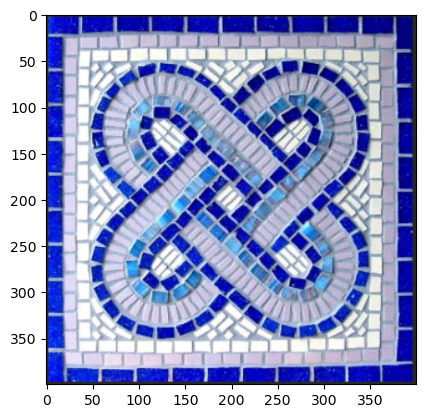

In [49]:
# import data and test compute_style_cost
# TODO later/ verify style cost

# Syle imge reading and preprocessing
img_size = 400

# Style image initialization
style_img_path = os.path.join('.','Neural-Style-Transfer-with-Python/style imgs/abstract mosaic art style.PNG')

style_image =  cv2.resize(cv2.imread(style_img_path), (img_size, img_size))
print(style_image.shape)
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
style_image_rgb = cv2.cvtColor(style_image[0].numpy(), cv2.COLOR_BGR2RGB)
plt.imshow(style_image_rgb)
#plt.show()


In [51]:
"""import PIL.Image as Image
c = np.array(Image.open("/content/Cat03.jpg").resize((img_size, img_size)))
print(c[20 ,20])"""

'import PIL.Image as Image\nc = np.array(Image.open("/content/Cat03.jpg").resize((img_size, img_size)))\nprint(c[20 ,20])'

(400, 400, 3)
(400, 400, 3)
tf.Tensor([224 238 244], shape=(3,), dtype=uint8)


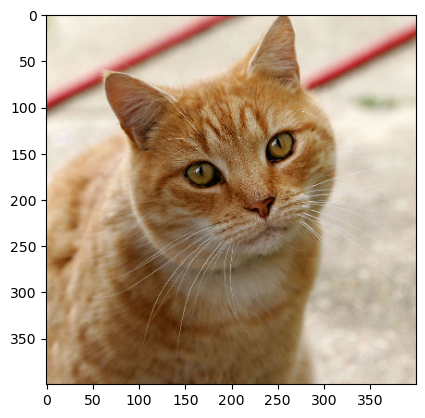

In [52]:
# content image initialization
content_img_path = os.path.join('.','Neural-Style-Transfer-with-Python','content imgs', 'Cat03.jpg')
content_image =  cv2.resize(cv2.imread(content_img_path), (img_size, img_size))
print(content_image.shape)
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

# display purposes only
content_image_rgb = cv2.cvtColor(content_image[0].numpy(), cv2.COLOR_BGR2RGB)
print(content_image_rgb.shape)
print(content_image[0, 20 ,20])
plt.imshow(content_image_rgb)

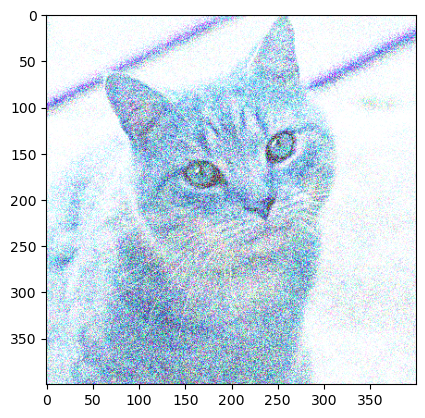

In [53]:
# initialize and preprocess generated image
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.8)
generated_image = tf.add(generated_image, noise)
generated_image_preprocessed = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
generated_image_preprocessed = tf.Variable(generated_image_preprocessed, tf.float32)
plt.imshow(generated_image_preprocessed[0].numpy())


In [54]:
# preprocess style and content images 
content_img_preprocessed = tf.image.convert_image_dtype(content_image, tf.float32)
style_img_preprocessed = tf.image.convert_image_dtype(style_image, tf.float32)

In [55]:
vgg_input_shape = (400, 400, 3)
model = VGG19(input_shape = vgg_input_shape, include_top= False, weights = 'imagenet')
model.trainable = False

In [56]:
# initiaalize models 
c_m = create_content_model(model = model, layer_name = 'block2_conv2', layer_index = None)

layer_names = layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 
                             'block4_conv1', 'block5_conv1']
s_m = create_style_model(model = model, layer_names = layer_names)
# initialize activations
a_c = c_m(content_img_preprocessed)
a_s = s_m(style_img_preprocessed)

# initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


In [57]:
#s_m.summary()
print(len(s_m(generated_image_preprocessed)))
print(s_m.output_shape)
print(len(a_s))

5
[(None, 400, 400, 64), (None, 200, 200, 128), (None, 100, 100, 256), (None, 50, 50, 512), (None, 25, 25, 512)]
5


Epoch : 0 -- Cost = 34490.98828125
Epoch : 1000 -- Cost = 5569.22998046875
Epoch : 2000 -- Cost = 2886.57568359375
Epoch : 3000 -- Cost = 1892.0771484375
Epoch : 4000 -- Cost = 1345.181640625
Epoch : 5000 -- Cost = 1011.672119140625
Epoch : 6000 -- Cost = 791.5203247070312
Epoch : 7000 -- Cost = 645.0241088867188
Epoch : 8000 -- Cost = 542.517333984375
Epoch : 9000 -- Cost = 467.2771911621094
Epoch : 10000 -- Cost = 411.15606689453125
Epoch : 11000 -- Cost = 369.7388610839844
Epoch : 12000 -- Cost = 342.1739196777344
Epoch : 13000 -- Cost = 323.81884765625
Epoch : 14000 -- Cost = 312.05999755859375
Compute time 1003.1636486053467 s


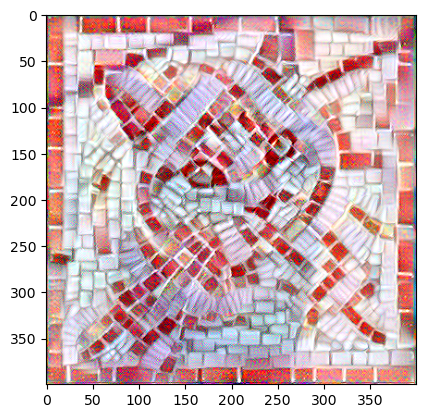

In [60]:
beg = time.time()
for i in range(15000):

    with tf.GradientTape() as tape:
        # generated activations here generated_img
        a_g = c_m(generated_image_preprocessed)
        content_cost = compute_content_cost(a_c, a_g)

        a_g = s_m(generated_image_preprocessed)
        style_cost = compute_style_cost(a_s, a_g, layer_weights = None)

        cost = compute_total_cost(content_cost, style_cost, alpha = 100, beta = 100)
        #print(f'--Cost = {float(cost.numpy())}', end =' ')


    grads = tape.gradient(cost, generated_image_preprocessed)
    optimizer.apply_gradients([(grads, generated_image_preprocessed)])
    if i % 1000 == 0:

        print(f'Epoch : {i} -- Cost = {float(cost.numpy())}')
    # add 0_1 clipping here    
    generated_image_preprocessed.assign(clip_0_1(generated_image_preprocessed))
    
# bgr display
plt.imshow(generated_image_preprocessed[0].numpy())
end = time.time()
print(f'Compute time {end - beg} s')

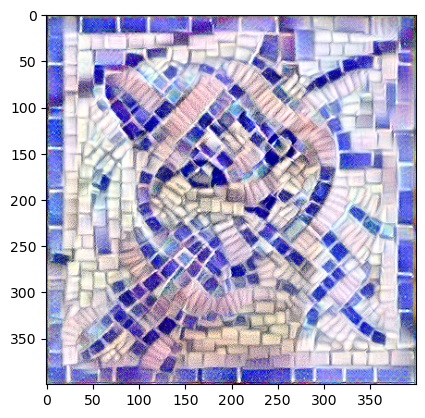

In [61]:
# rgb display
plt.imshow(generated_image_preprocessed[0].numpy()[..., ::-1])

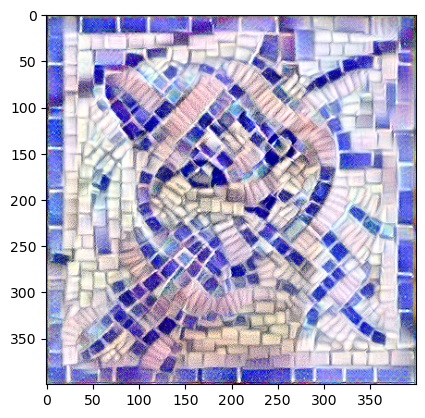

In [63]:
plt.imshow(generated_image_preprocessed[0].numpy()[..., ::-1])
plt.savefig('figure.png')


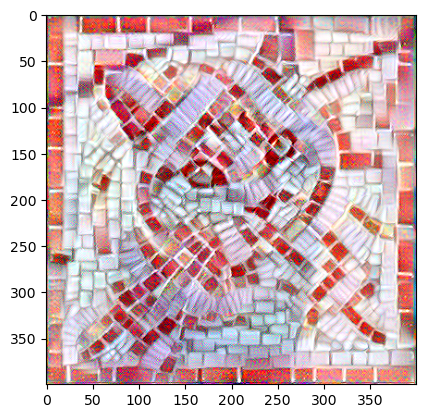

In [64]:
plt.imshow(generated_image_preprocessed[0].numpy())
plt.savefig('figure.png')
